In [1]:
%run Data_Helpers.ipynb
%run Decision_Tree_Helpers.ipynb

import sklearn.tree
import pandas as pd
import re

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Thanks, https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
def get_title(name):
    title_search = re.search(r'\b([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

def prepare_data(df):
    df = df.filter(items=[
        'name',
        'sex',
        'age',
        'sibsp',
        'parch',
        'ticket',
        'fare',
        'pclass',
        'cabin',
        'embarked',
        'home.dest',
        'survived'
    ])
    extract_unknown(df, 'age')
    extract_unknown(df, 'fare')
    split_categories(df, 'sex', ['male', 'female'])
    split_categories(df, 'pclass', ['1', '2', '3'])
    split_categories(df, 'embarked', ['S', 'C', 'Q'])
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['alone'] = df['family_size'] == 1
    df['title'] = df['name'].apply(get_title)
    df['title_Rare'] = df['title'].isin([
        'Lady', 'Countess', 'Dona',
        'Sir', 'Don',
        'Col', 'Capt', 'Rev', 'Dr', 'Major', 'Jonkheer',
    ]).astype(int)
    split_categories(df, 'title', [
        'Mrs', 'Ms', 'Miss', 'Mme', 'Mlle', 'Dona', 'Lady', 'Countess',
        'Mr', 'Master',                     'Sir', 'Don',
        'Col', 'Capt', 'Rev', 'Dr', 'Major', 'Jonkheer',
    ])
    return df

In [3]:
raw_data = pd.read_csv('data/titanic.csv')
[raw_train_data, raw_test_data, raw_validate_data] = divide_data(raw_data, [0.8, 0.1, 0.1])

In [4]:
train_data = prepare_data(raw_train_data)
test_data = prepare_data(raw_test_data)
validate_data = prepare_data(raw_validate_data)

In [5]:
display_wide(train_data.head())

,name,sex_male,sex_female,age_known,age,sibsp,parch,ticket,fare_known,fare,pclass_1,pclass_2,pclass_3,cabin,embarked_S,embarked_C,embarked_Q,home.dest,survived,family_size,alone,title_Mrs,title_Ms,title_Miss,title_Mme,title_Mlle,title_Dona,title_Lady,title_Countess,title_Mr,title_Master,title_Sir,title_Don,title_Col,title_Capt,title_Rev,title_Dr,title_Major,title_Jonkheer,title_Rare
693,"Buckley, Mr. Daniel",1,0,1,21.0,0,0,330920,1,7.8208,0,0,1,NaN,0,0,1,"Kingwilliamstown, Co Cork, Ireland New York, NY",1,1,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
220,"Ostby, Miss. Helene Ragnhild",0,1,1,22.0,0,1,113509,1,61.9792,1,0,0,B36,0,1,0,"Providence, RI",1,2,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
556,"Sharp, Mr. Percival James R",1,0,1,27.0,0,0,244358,1,26.0000,0,1,0,NaN,1,0,0,"Hornsey, England",0,1,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
752,"Davies, Mr. Alfred J",1,0,1,24.0,2,0,A/4 48871,1,24.1500,0,0,1,NaN,1,0,0,"West Bromwich, England Pontiac, MI",0,3,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,"Artagaveytia, Mr. Ramon",1,0,1,71.0,0,0,PC 17609,1,49.5042,1,0,0,NaN,0,1,0,"Montevideo, Uruguay",0,1,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [6]:
def make_model_output(df):
    return df.filter(items=['survived'])

def make_model(df_in, df_out):
    return sklearn.tree.DecisionTreeClassifier(max_depth = 3)

In [7]:
results = train_decision_trees(make_model, train_data, test_data, [
    InputFn('none', lambda df: df.filter(items=[]).assign(One=1)),
    InputFn('sex', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
    ])),
    InputFn('title', lambda df: df.filter(items=[
        *find_columns(df, 'title'),
    ])),
    InputFn('all', lambda df: df.filter(items=[
        *find_columns(df, 'sex'),
        'age_known',
        'age',
        'fare_known',
        'fare',
        'sibsp',
        'parch',
        'family_size',
        *find_columns(df, 'pclass'),
        *find_columns(df, 'embarked'),
        *find_columns(df, 'title'),
    ])),
], make_model_output, class_names = ['died', 'survived'])

Fitting none...
  train: accuracy = 0.617    test: accuracy = 0.6031
Fitting sex...
  train: accuracy = 0.7775    test: accuracy = 0.771
Fitting title...
  train: accuracy = 0.7746    test: accuracy = 0.7863
Fitting all...
  train: accuracy = 0.8185    test: accuracy = 0.7863
Training complete


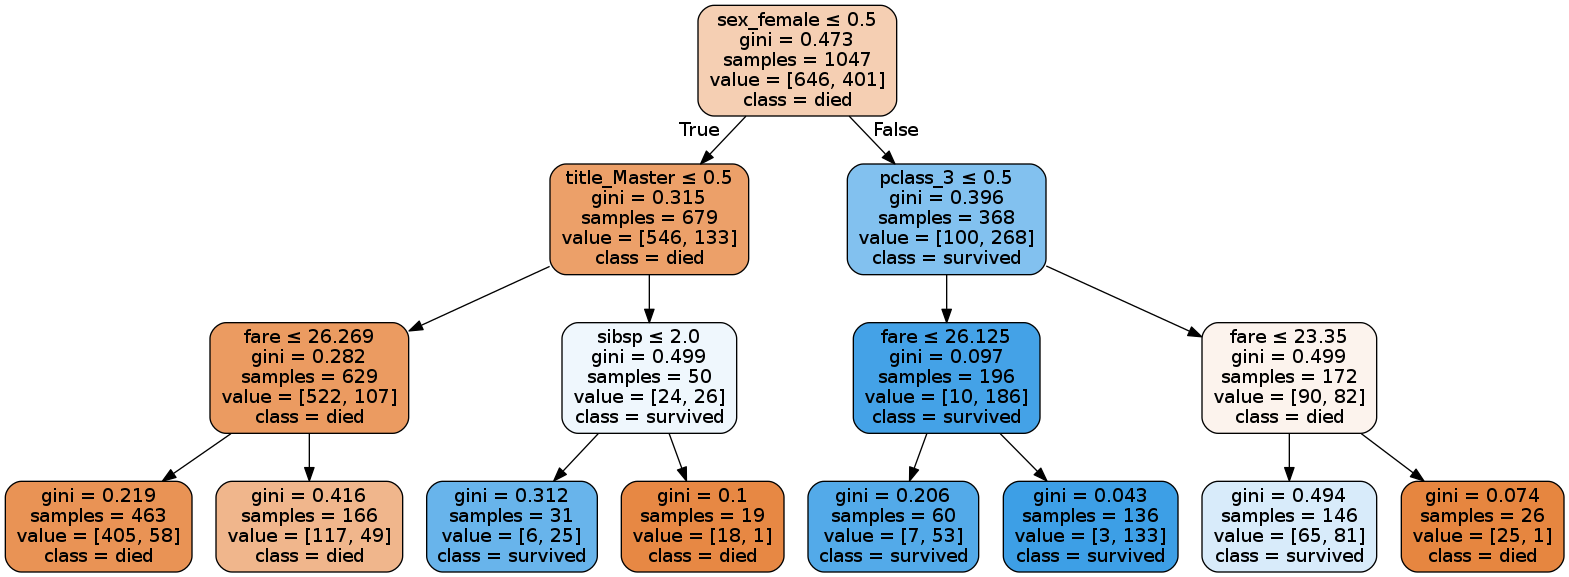

In [8]:
show_tree(results['all'].model)

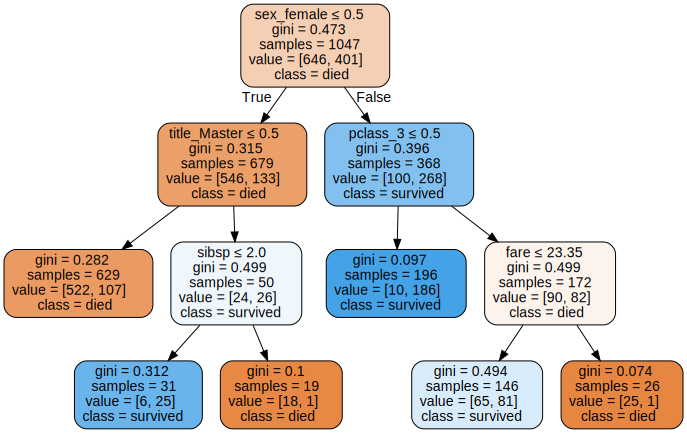

In [9]:
show_tree(prune_decision_tree(results['all'].model), fullSize=True)